In [3]:
# import libraries

import numpy as np
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM

from sklearn.model_selection import StratifiedShuffleSplit

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

from os.path import basename
import cv2
from mtcnn.mtcnn import MTCNN

2023-01-12 13:37:12.283508: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
def crop_image(img1):
    detector1 = MTCNN() 
    #pic = Image.open(img1)
    img = np.array(img1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # detect faces in the image
    faces1 = detector1.detect_faces(img_rgb)


    #MTCNN
    for result in faces1:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h

        faces = img_rgb[y:y+h, x:x+w]

    print(faces.shape)


    ######
    if len(faces)==0:

        img = Image.fromarray(img_array)
    else:    

        img = Image.fromarray(faces)
    im =Image.fromarray(np.uint8(img))
    return img

In [40]:
#Augmentation process 
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                               # transforms.GaussianBlur(7, sigma=(2, 4)),
                                
                                
                               # transforms.RandomRotation(degrees=50,expand=True),
                                #transforms.Resize((224,224)),     
                               transforms.ToTensor(),
                             
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
              transforms.Normalize((0.4839, 0.4839, 0.4839),(0.2709, 0.2709, 0.2709)),
                                
                               
                               ])



transform2 = transforms.Compose([transforms.RandomEqualize(1),
                                transforms.GaussianBlur(7, sigma=(2, 4)),
                                 transforms.Resize((224,224)),
          
                               transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
              transforms.Normalize((0.4839, 0.4839, 0.4839),(0.2709, 0.2709, 0.2709)),
                               ])
transform1 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
                              # transforms.Normalize((0.4654, 0.4654, 0.4654),(0.2718, 0.2718, 0.2718)),
                               ])

transform4 = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                transforms.GaussianBlur(7, sigma=(2, 4)),
                                 transforms.Resize((224,224)),
                                 #transforms.RandomHorizontalFlip(p=1),
                                 #transforms.RandomEqualize(1),
                                 #transforms.RandomAutocontrast(1),
                                 transforms.ToTensor(),
              transforms.Normalize((0.4839, 0.4839, 0.4839),(0.2709, 0.2709, 0.2709)),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
                               ])
transform5 = transforms.Compose([
                                 
                                 
                                 transforms.Resize((224,224)),
                                 transforms.GaussianBlur(7, sigma=(4, 8)),
                                 transforms.RandomAutocontrast(1),
                                 transforms.ToTensor(),
                         
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),

              transforms.Normalize((0.4839, 0.4839, 0.4839),(0.2709, 0.2709, 0.2709)),
                                ])
transform6 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                 transforms.Resize((224,224)),
                                 #transforms.RandomEqualize(1),
                                 transforms.RandomRotation(degrees=50),
                                 #transforms.RandomAutocontrast(1),
                               # transforms.RandomHorizontalFlip(p=1),
                                 transforms.ToTensor(),
                             #  transforms.Normalize((0.5559, 0.5559, 0.5559),(0.3484, 0.3484, 0.3484)),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
                                ])
transform7 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                 transforms.Resize((224,224)),
                                 transforms.RandomEqualize(1),
                                # transforms.RandomRotation(degrees=50),
                                 #transforms.RandomAutocontrast(1),
                                transforms.RandomHorizontalFlip(p=0.2),
                                 transforms.ToTensor(),
                              # transforms.Normalize((0.5079, 0.5079, 0.5079),(0.2500, 0.2500, 0.2500)),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
                                ])

In [41]:
train_validation_dataset =torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/lbp',transform = transform)
print(len(train_validation_dataset))

213


In [42]:
set1 = torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/cropped',transform = transform)
set2 = torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/cropped',transform = transform2)
set3 =torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/cropped',transform = transform4)
set4 =torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/cropped',transform = transform5)

In [43]:
train_validation_dataset = torch.utils.data.ConcatDataset([set1,set2,set3,set4])
print(len(train_validation_dataset))

852


In [44]:
from torch.utils.data import Dataset, DataLoader, random_split
validation_size = 128
train_size = len(train_validation_dataset)-128
train_dataset, validation_dataset = random_split(train_validation_dataset,
                                                (train_size, validation_size))
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size*2, shuffle=True, num_workers=0, pin_memory=True)

#test_loader = DataLoader(test_dataset, batch_size*2, shuffle=True, num_workers=6, pin_memory=True)

validation_loader = DataLoader(validation_dataset, batch_size, num_workers=0, pin_memory=True)


In [45]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [46]:
mean , std = get_mean_and_std(train_loader)

print(mean)
print(std)

tensor([0.0019, 0.0019, 0.0019])
tensor([1.0003, 1.0003, 1.0003])


In [47]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        print("Image Shape : ", images.shape)
        plt.figure(figsize=(128,128))
        plt.axis('off')
        plt.imshow(make_grid(images, nrows=8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Shape :  torch.Size([32, 3, 224, 224])


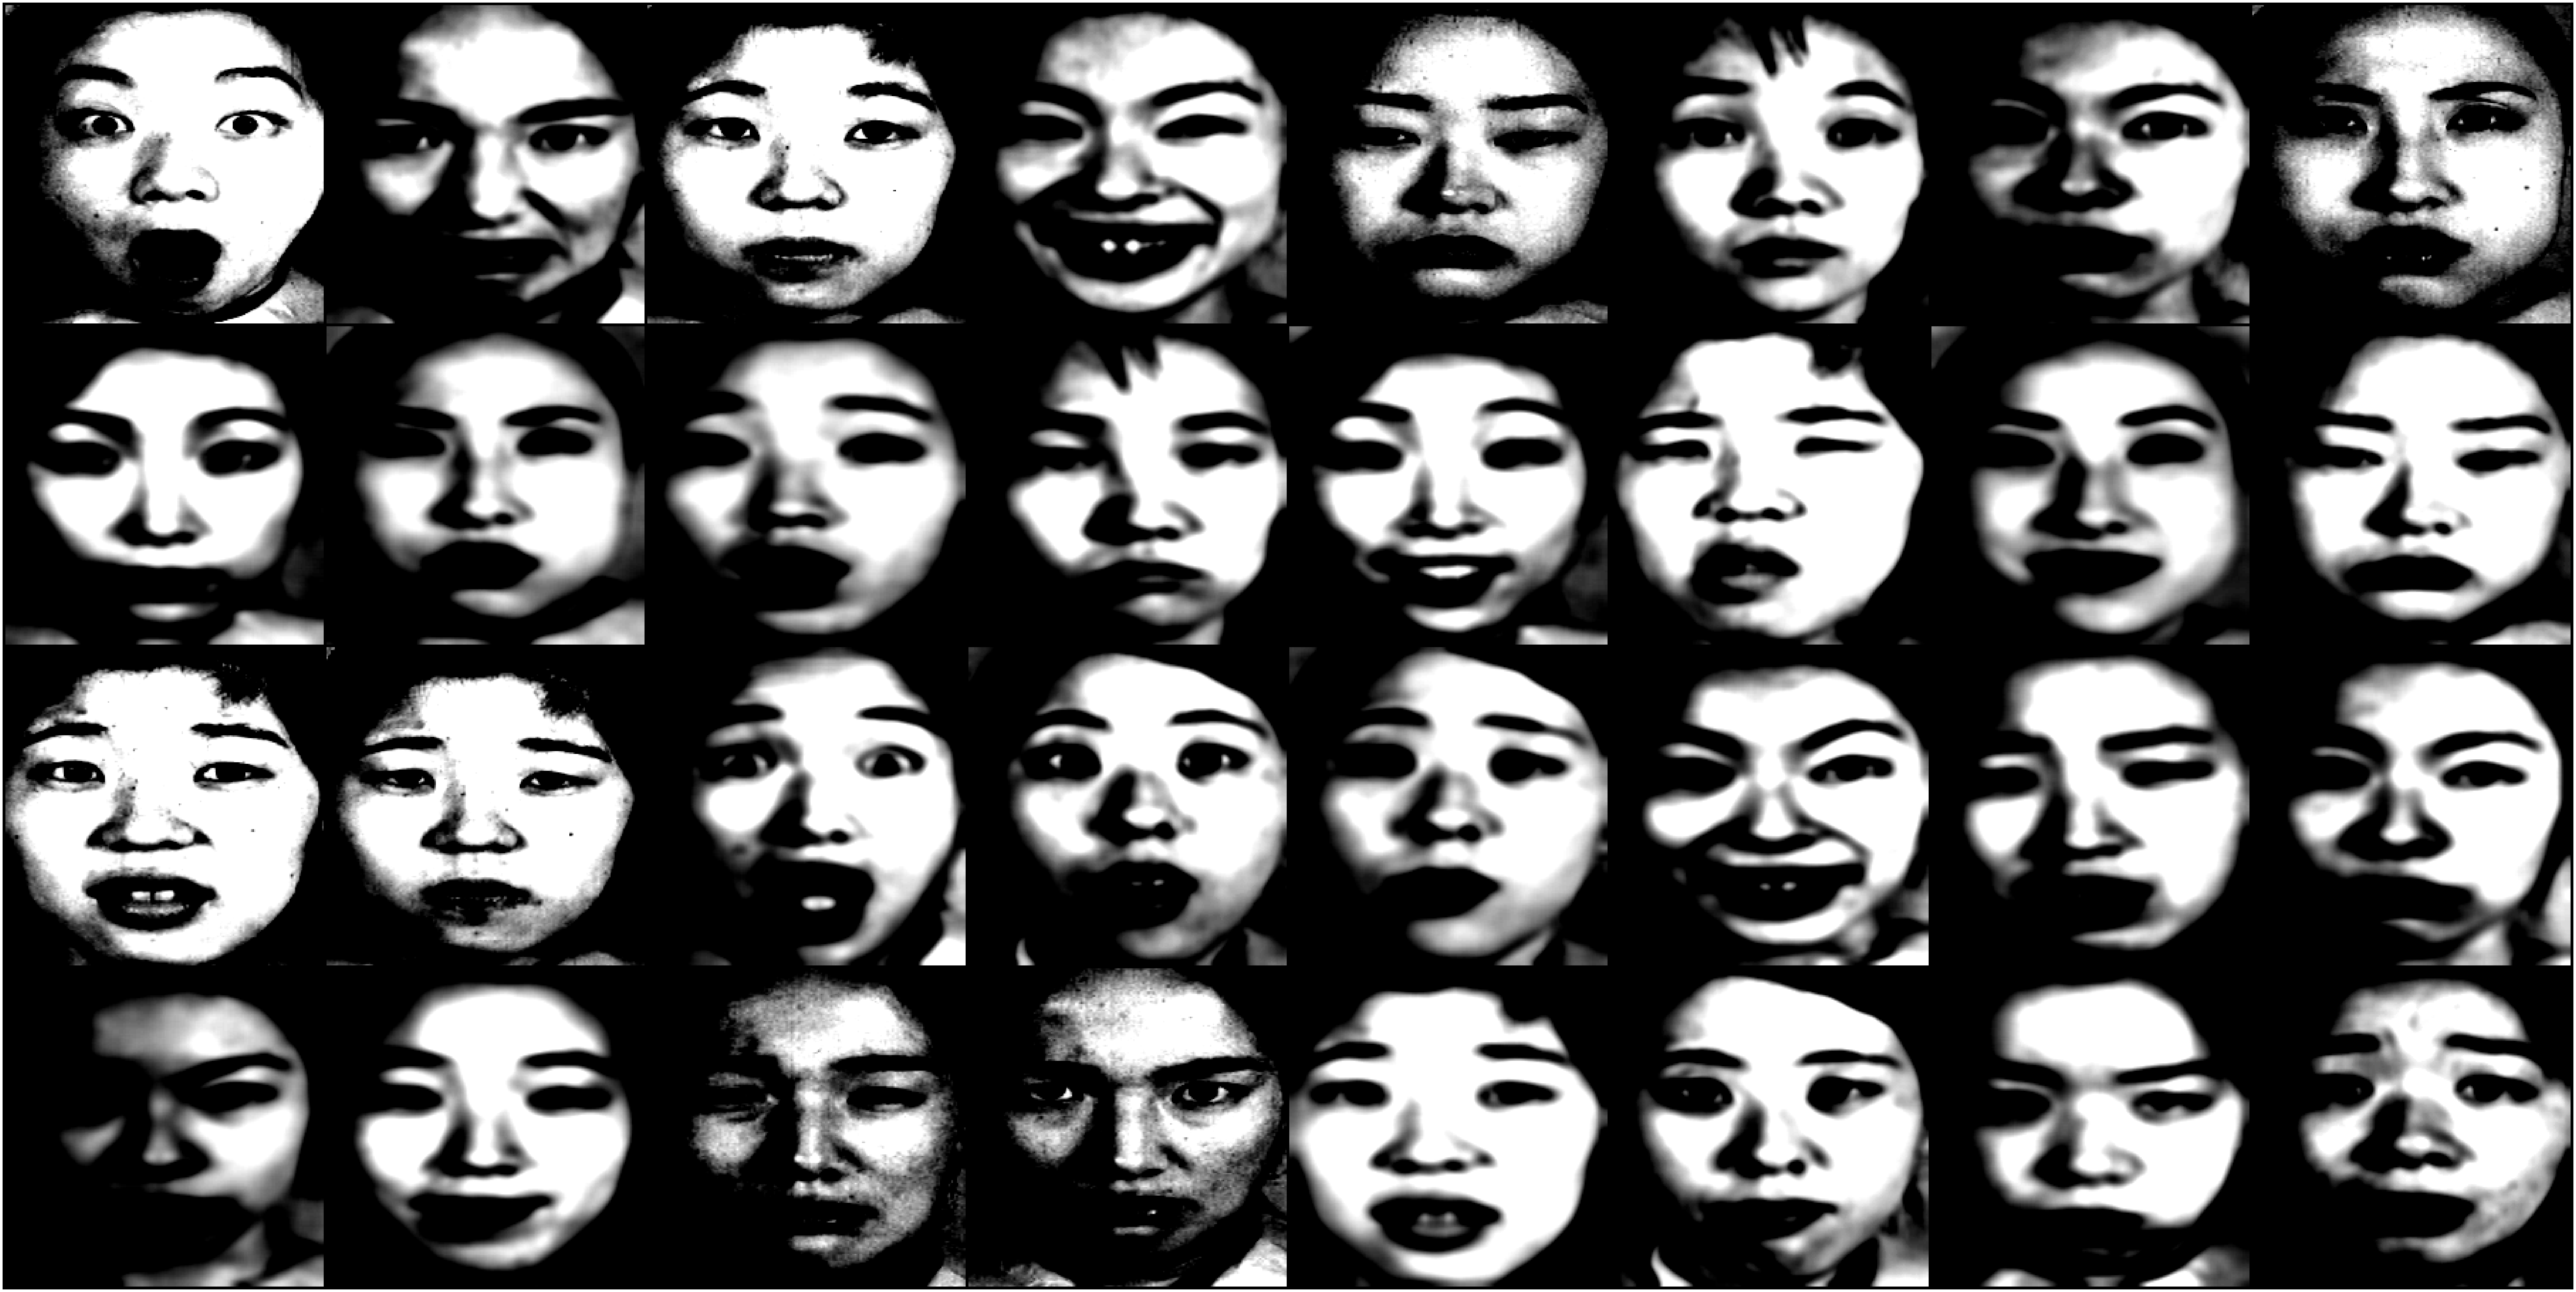

In [48]:
show_batch(train_loader)

In [49]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [50]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class deviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [51]:

use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [52]:
train_dl = deviceDataLoader(train_loader, device)
val_dl = deviceDataLoader(validation_loader, device)
print(len(val_dl))

8


In [53]:
model = models.vgg16(pretrained=True)
ct=0
for child in model.children():
    ct += 1
    if ct < 8:
        for param in child.parameters():
            param.requires_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
model.classifier = nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(25088, 7),
   
)

model.classifier = model.classifier.cuda() if use_cuda else model.fc
print(model)

/home/ali/miniconda3/envs/Alitf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ali/miniconda3/envs/Alitf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
class Trainer():
    def __init__(self, model, train, val, criterion, optim_fn, device ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optim_fn
        self.train_dl = train
        self.val_dl = val
        self.device = device
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []

    def train(self, epochs =1):
        self.model = self.model.to(self.device)

        for i in range(epochs):
            print('Epoch : ', i)
            loss = 0.0
            acc = 0.0

            print("'''''Training'''''")
            # Set train mode
            self.model.train()

            # tqdm
            with tqdm(self.train_dl, unit = 'batch') as train_dl:
                for X, y in train_dl:


              ################### ####################
              ## Data on GPU
                    X = X.to(self.device, non_blocking = True)
                    y = y.to(self.device, non_blocking = True)

                  ## Set Gradient = 0
                    self.optimizer.zero_grad()

                  ## Calculate loss
                    out = self.model(X)
                    batch_loss = self.criterion(out, y)

                  ## Gradient Step
                    batch_loss.backward()
                    self.optimizer.step()

                    with torch.no_grad():
                        loss += batch_loss.item()
                        _, pred = torch.max(out, dim = 1)
                        acc += torch.sum(pred == y).item() / len(y)
                  ########################################################


                    train_dl.set_postfix(loss = loss / len(train_dl), accuracy = 100.0 * acc / len(train_dl))

                self.train_loss.append(loss / len(train_dl))
                self.train_acc.append(100.0 * acc / len(train_dl))

            # set Validation mode
            print("'''Validation'''")
            self.model.eval()

            with torch.no_grad():
                with tqdm(self.val_dl, unit = 'batch') as val_dl:
                    val_loss = 0.0
                    val_acc = 0.0 
                ################### ####################
                    for X, y in val_dl:
                        X = X.to(self.device)
                        y = y.to(self.device)

                        out = self.model(X)

                        val_loss += self.criterion(out, y).item()

                        _, pred = torch.max(out, dim =1)

                        val_acc += torch.sum(pred == y).item() / len(y)

                  ######################################################
                        val_dl.set_postfix(loss = val_loss / len(val_dl), accuracy = 100.0 * val_acc / len(val_dl))

                    self.valid_loss.append(val_loss / len(val_dl))
                    self.valid_acc.append(100.0 * val_acc / len(val_dl))
            scheduler.step()

        return {'train_history' : (self.train_loss, self.train_acc), 'valid_history' : (self.valid_loss, self.valid_acc)}

In [57]:
criterion = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 , weight_decay=1e-4 )
#metric_fc = ArcMarginProduct(512, 7 , s=30, m=0.5, easy_margin=False)
#optimizer = torch.optim.SGD([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                               # lr=1e-5, momentum=0.9,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.33)
sced = torch.optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.33)

trainer = Trainer(model, train_dl, val_dl, criterion, optimizer, device  )

In [58]:
%%time


history = trainer.train(100)

Epoch :  0
'''''Training'''''


100%|██████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.10batch/s, accuracy=55.9, loss=1.24]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.16batch/s, accuracy=76.6, loss=0.714]


Epoch :  1
'''''Training'''''


100%|███████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.20batch/s, accuracy=93, loss=0.277]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.75batch/s, accuracy=86.7, loss=0.396]


Epoch :  2
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=99.2, loss=0.0998]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.30batch/s, accuracy=94.5, loss=0.249]


Epoch :  3
'''''Training'''''


100%|██████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.054]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.07batch/s, accuracy=94.5, loss=0.231]


Epoch :  4
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.34batch/s, accuracy=99.7, loss=0.0388]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.80batch/s, accuracy=94.5, loss=0.222]


Epoch :  5
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.0298]


'''Validation'''


100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.40batch/s, accuracy=93, loss=0.216]


Epoch :  6
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.0228]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.11batch/s, accuracy=93.8, loss=0.187]


Epoch :  7
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.42batch/s, accuracy=100, loss=0.0192]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.54batch/s, accuracy=96.9, loss=0.177]


Epoch :  8
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.41batch/s, accuracy=100, loss=0.0165]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.23batch/s, accuracy=96.1, loss=0.157]


Epoch :  9
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.36batch/s, accuracy=100, loss=0.0137]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.54batch/s, accuracy=95.3, loss=0.166]


Epoch :  10
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.31batch/s, accuracy=100, loss=0.0116]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.13batch/s, accuracy=96.9, loss=0.157]


Epoch :  11
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.31batch/s, accuracy=100, loss=0.0111]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.12batch/s, accuracy=94.5, loss=0.159]


Epoch :  12
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.38batch/s, accuracy=100, loss=0.00948]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.44batch/s, accuracy=97.7, loss=0.143]


Epoch :  13
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.41batch/s, accuracy=100, loss=0.0086]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.39batch/s, accuracy=96.9, loss=0.139]


Epoch :  14
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.41batch/s, accuracy=100, loss=0.00776]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.55batch/s, accuracy=96.1, loss=0.145]


Epoch :  15
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.40batch/s, accuracy=100, loss=0.00698]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.47batch/s, accuracy=97.7, loss=0.136]


Epoch :  16
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.41batch/s, accuracy=100, loss=0.00671]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.53batch/s, accuracy=96.1, loss=0.136]


Epoch :  17
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.00572]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.20batch/s, accuracy=96.9, loss=0.136]


Epoch :  18
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.28batch/s, accuracy=100, loss=0.00551]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.35batch/s, accuracy=97.7, loss=0.129]


Epoch :  19
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.40batch/s, accuracy=100, loss=0.00531]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.06batch/s, accuracy=96.9, loss=0.124]


Epoch :  20
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00482]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.36batch/s, accuracy=97.7, loss=0.126]


Epoch :  21
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.25batch/s, accuracy=100, loss=0.00441]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21batch/s, accuracy=96.1, loss=0.125]


Epoch :  22
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.31batch/s, accuracy=100, loss=0.00437]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.19batch/s, accuracy=96.9, loss=0.123]


Epoch :  23
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=100, loss=0.00427]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.07batch/s, accuracy=96.9, loss=0.124]


Epoch :  24
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.05batch/s, accuracy=100, loss=0.00393]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.44batch/s, accuracy=96.1, loss=0.122]


Epoch :  25
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00351]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.39batch/s, accuracy=96.9, loss=0.115]


Epoch :  26
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.00335]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.36batch/s, accuracy=96.9, loss=0.113]


Epoch :  27
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.36batch/s, accuracy=100, loss=0.00321]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.43batch/s, accuracy=96.9, loss=0.111]


Epoch :  28
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.36batch/s, accuracy=100, loss=0.00294]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.43batch/s, accuracy=97.7, loss=0.118]


Epoch :  29
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.00283]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.41batch/s, accuracy=96.9, loss=0.111]


Epoch :  30
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00279]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.19batch/s, accuracy=97.7, loss=0.113]


Epoch :  31
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00272]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.27batch/s, accuracy=97.7, loss=0.107]


Epoch :  32
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.28batch/s, accuracy=100, loss=0.00279]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.26batch/s, accuracy=96.1, loss=0.111]


Epoch :  33
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.23batch/s, accuracy=100, loss=0.00251]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.50batch/s, accuracy=96.9, loss=0.112]


Epoch :  34
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.35batch/s, accuracy=100, loss=0.00281]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.77batch/s, accuracy=96.9, loss=0.107]


Epoch :  35
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00259]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.44batch/s, accuracy=97.7, loss=0.108]


Epoch :  36
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.31batch/s, accuracy=100, loss=0.0028]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.46batch/s, accuracy=96.1, loss=0.111]


Epoch :  37
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00248]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.25batch/s, accuracy=96.1, loss=0.108]


Epoch :  38
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00252]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.37batch/s, accuracy=96.1, loss=0.109]


Epoch :  39
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.32batch/s, accuracy=100, loss=0.00264]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.89batch/s, accuracy=97.7, loss=0.107]


Epoch :  40
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00232]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.01batch/s, accuracy=96.1, loss=0.107]


Epoch :  41
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.30batch/s, accuracy=100, loss=0.00237]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.25batch/s, accuracy=96.1, loss=0.107]


Epoch :  42
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.22batch/s, accuracy=100, loss=0.00226]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.84batch/s, accuracy=96.1, loss=0.107]


Epoch :  43
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.60batch/s, accuracy=100, loss=0.0023]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.93batch/s, accuracy=96.1, loss=0.107]


Epoch :  44
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.43batch/s, accuracy=100, loss=0.00224]


'''Validation'''


100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.51batch/s, accuracy=96.1, loss=0.11]


Epoch :  45
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.69batch/s, accuracy=100, loss=0.00229]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 16.23batch/s, accuracy=96.1, loss=0.104]


Epoch :  46
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.11batch/s, accuracy=100, loss=0.0023]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.38batch/s, accuracy=97.7, loss=0.108]


Epoch :  47
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.39batch/s, accuracy=100, loss=0.00219]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.43batch/s, accuracy=96.9, loss=0.107]


Epoch :  48
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00213]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.26batch/s, accuracy=97.7, loss=0.104]


Epoch :  49
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.19batch/s, accuracy=100, loss=0.00208]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.87batch/s, accuracy=96.9, loss=0.105]


Epoch :  50
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00203]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.48batch/s, accuracy=96.9, loss=0.104]


Epoch :  51
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.37batch/s, accuracy=100, loss=0.00207]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.24batch/s, accuracy=97.7, loss=0.106]


Epoch :  52
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=100, loss=0.00189]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.22batch/s, accuracy=96.9, loss=0.107]


Epoch :  53
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.19batch/s, accuracy=100, loss=0.00197]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.95batch/s, accuracy=96.9, loss=0.106]


Epoch :  54
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.25batch/s, accuracy=100, loss=0.00188]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.34batch/s, accuracy=96.1, loss=0.111]


Epoch :  55
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.32batch/s, accuracy=100, loss=0.00177]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.30batch/s, accuracy=96.1, loss=0.106]


Epoch :  56
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.25batch/s, accuracy=100, loss=0.00188]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.31batch/s, accuracy=96.9, loss=0.105]


Epoch :  57
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.20batch/s, accuracy=100, loss=0.00181]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.34batch/s, accuracy=96.9, loss=0.108]


Epoch :  58
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=100, loss=0.00185]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.27batch/s, accuracy=96.1, loss=0.113]


Epoch :  59
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.18batch/s, accuracy=100, loss=0.00182]


'''Validation'''


100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.23batch/s, accuracy=95.3, loss=0.11]


Epoch :  60
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=100, loss=0.00187]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.98batch/s, accuracy=96.1, loss=0.102]


Epoch :  61
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.27batch/s, accuracy=100, loss=0.00187]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.25batch/s, accuracy=96.1, loss=0.106]


Epoch :  62
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.29batch/s, accuracy=100, loss=0.00173]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.22batch/s, accuracy=96.1, loss=0.105]


Epoch :  63
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.27batch/s, accuracy=100, loss=0.00169]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.28batch/s, accuracy=96.1, loss=0.104]


Epoch :  64
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.21batch/s, accuracy=100, loss=0.00176]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.94batch/s, accuracy=96.1, loss=0.105]


Epoch :  65
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.27batch/s, accuracy=100, loss=0.0016]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.23batch/s, accuracy=95.3, loss=0.109]


Epoch :  66
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.27batch/s, accuracy=100, loss=0.00172]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.85batch/s, accuracy=96.1, loss=0.105]


Epoch :  67
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.15batch/s, accuracy=100, loss=0.00182]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.26batch/s, accuracy=96.9, loss=0.105]


Epoch :  68
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.12batch/s, accuracy=100, loss=0.00167]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.09batch/s, accuracy=96.1, loss=0.104]


Epoch :  69
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.21batch/s, accuracy=100, loss=0.00169]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.07batch/s, accuracy=96.1, loss=0.107]


Epoch :  70
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.13batch/s, accuracy=100, loss=0.00179]


'''Validation'''


100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.16batch/s, accuracy=96.9, loss=0.1]


Epoch :  71
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.14batch/s, accuracy=100, loss=0.00164]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.27batch/s, accuracy=96.9, loss=0.105]


Epoch :  72
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.24batch/s, accuracy=100, loss=0.00162]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.94batch/s, accuracy=96.1, loss=0.102]


Epoch :  73
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.18batch/s, accuracy=100, loss=0.00163]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21batch/s, accuracy=95.3, loss=0.105]


Epoch :  74
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.25batch/s, accuracy=100, loss=0.00162]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.17batch/s, accuracy=96.9, loss=0.107]


Epoch :  75
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.15batch/s, accuracy=100, loss=0.00163]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.20batch/s, accuracy=96.9, loss=0.104]


Epoch :  76
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.23batch/s, accuracy=100, loss=0.00164]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.99batch/s, accuracy=96.9, loss=0.106]


Epoch :  77
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.21batch/s, accuracy=100, loss=0.00167]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.15batch/s, accuracy=96.9, loss=0.104]


Epoch :  78
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.23batch/s, accuracy=100, loss=0.00167]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21batch/s, accuracy=96.9, loss=0.105]


Epoch :  79
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.23batch/s, accuracy=100, loss=0.00164]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.13batch/s, accuracy=96.9, loss=0.105]


Epoch :  80
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.22batch/s, accuracy=100, loss=0.00156]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.00batch/s, accuracy=96.1, loss=0.102]


Epoch :  81
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.13batch/s, accuracy=100, loss=0.00153]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.80batch/s, accuracy=96.1, loss=0.103]


Epoch :  82
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.25batch/s, accuracy=100, loss=0.00168]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.43batch/s, accuracy=96.9, loss=0.103]


Epoch :  83
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.34batch/s, accuracy=100, loss=0.00152]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.34batch/s, accuracy=96.9, loss=0.103]


Epoch :  84
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.32batch/s, accuracy=100, loss=0.00167]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.41batch/s, accuracy=96.1, loss=0.104]


Epoch :  85
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.32batch/s, accuracy=100, loss=0.00153]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.32batch/s, accuracy=96.1, loss=0.106]


Epoch :  86
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.34batch/s, accuracy=100, loss=0.0016]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.30batch/s, accuracy=96.9, loss=0.102]


Epoch :  87
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00158]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.14batch/s, accuracy=96.1, loss=0.104]


Epoch :  88
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.33batch/s, accuracy=100, loss=0.00152]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.27batch/s, accuracy=96.9, loss=0.104]


Epoch :  89
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.31batch/s, accuracy=100, loss=0.00151]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.28batch/s, accuracy=96.9, loss=0.102]


Epoch :  90
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.21batch/s, accuracy=100, loss=0.00151]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.07batch/s, accuracy=96.9, loss=0.103]


Epoch :  91
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.12batch/s, accuracy=100, loss=0.00157]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.82batch/s, accuracy=96.9, loss=0.104]


Epoch :  92
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.24batch/s, accuracy=100, loss=0.00154]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.12batch/s, accuracy=96.9, loss=0.102]


Epoch :  93
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.16batch/s, accuracy=100, loss=0.00154]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.88batch/s, accuracy=96.9, loss=0.105]


Epoch :  94
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.18batch/s, accuracy=100, loss=0.00156]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.12batch/s, accuracy=96.9, loss=0.106]


Epoch :  95
'''''Training'''''


100%|█████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.17batch/s, accuracy=100, loss=0.0016]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.19batch/s, accuracy=96.9, loss=0.101]


Epoch :  96
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.93batch/s, accuracy=100, loss=0.00145]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.21batch/s, accuracy=96.1, loss=0.104]


Epoch :  97
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.24batch/s, accuracy=100, loss=0.00145]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.21batch/s, accuracy=96.9, loss=0.102]


Epoch :  98
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.17batch/s, accuracy=100, loss=0.00148]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.42batch/s, accuracy=96.9, loss=0.102]


Epoch :  99
'''''Training'''''


100%|████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.36batch/s, accuracy=100, loss=0.00144]


'''Validation'''


100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.00batch/s, accuracy=96.9, loss=0.103]

CPU times: user 35min 5s, sys: 16.6 s, total: 35min 21s
Wall time: 4min 25s


In [59]:
def plot_accuracies(history):
    train_loss, train_acc = history['train_history']
    val_loss, val_acc = history['valid_history']
    plt.plot(train_acc, '-b')
    plt.plot(val_acc, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation']) 
    plt.title('Accuracy vs. No. of epochs');
    

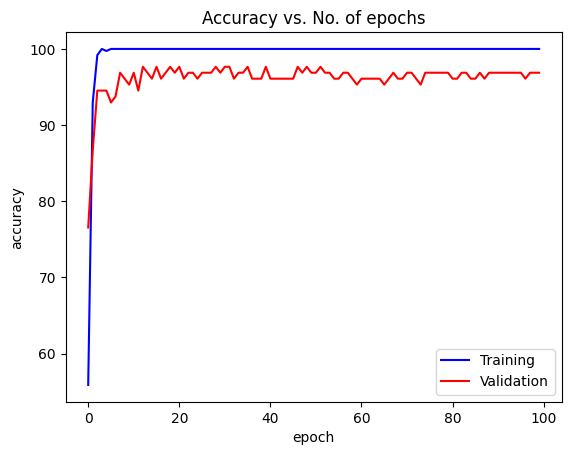

In [60]:
plot_accuracies(history)


In [61]:
testset =torchvision.datasets.ImageFolder(root = '/storage/ali/FER/JAFFE/cropped',transform = transform)

In [67]:
test_loader= DataLoader(testset, batch_size*2, shuffle=True, num_workers=0, pin_memory=True)

In [68]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [69]:
test_dl = deviceDataLoader(test_loader, device)
check_accuracy(test_dl,model)

Got 209 / 213 with accuracy 98.12


In [70]:
test_dl = deviceDataLoader(test_loader, device)
check_accuracy(test_dl,model)

Got 209 / 213 with accuracy 98.12


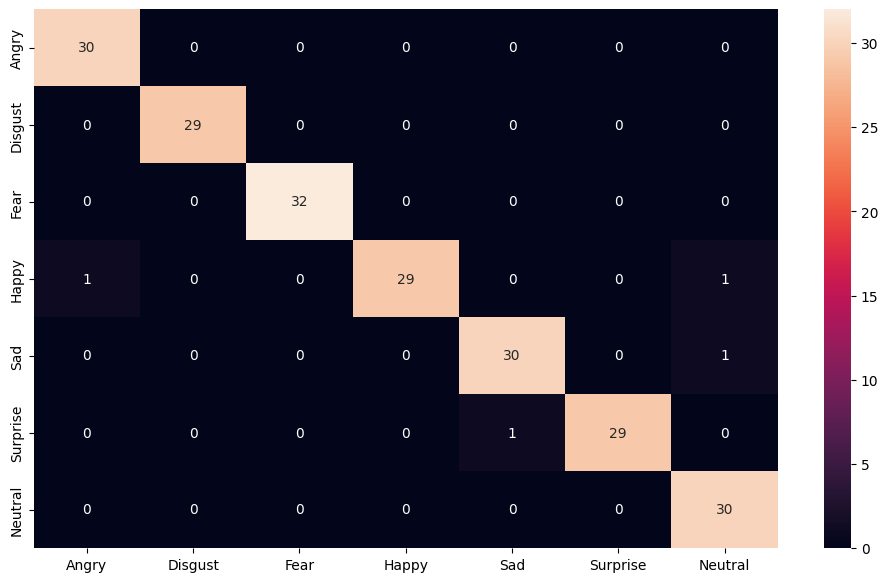

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dl:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')